## Практическая работа №1. Азат Сибагатулин

In [ ]:
 !pip install scipy matplotlib statsmodels pandas seaborn tqdm scikit-learn numba tweedie

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import scipy.stats as stats
from tweedie.tweedie_dist import tweedie_gen

import matplotlib.pyplot as plt
import seaborn as sns

import os
from tqdm import tqdm
from sklearn.utils import shuffle
import hashlib
from typing import Callable
from base64 import b64encode
import collections
import datetime

from numba import njit, float32
from joblib import Parallel, delayed

In [2]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 20000)

## Загрузка KION датасета

In [ ]:
import requests

# download dataset by chunks
url = "https://github.com/sharthZ23/your-second-recsys/raw/master/data_kion.zip"

req = requests.get(url, stream=True)

with open('data_kion.zip', "wb") as fd:
    total_size_in_bytes = int(req.headers.get('Content-Length', 0))
    progress_bar = tqdm(desc='kion dataset download', total=total_size_in_bytes, unit='iB', unit_scale=True)
    for chunk in req.iter_content(chunk_size=2 ** 20):
        progress_bar.update(len(chunk))
        fd.write(chunk)

In [ ]:
# Распаковываем архив из 3 файлов
import zipfile

with zipfile.ZipFile('data_kion.zip', 'r') as zip_ref:
    zip_ref.extractall()

## 1. Извлекаем просмотры 

 - за последнюю неделю ```week1```
 - за две последних недели ```week2```

In [3]:
interactions = pd.read_csv('data_kion/interactions_df.csv')

interactions['last_watch_dt'] = pd.to_datetime(interactions['last_watch_dt']).map(lambda x: x.date())
interactions['user_id'] = interactions['user_id'].astype(str)

In [4]:
max_date = interactions['last_watch_dt'].max()

week1 = interactions[interactions['last_watch_dt'] >= max_date - datetime.timedelta(days=7)]
week1 = week1.groupby('user_id', as_index=False)["total_dur"].sum()
week1.total_dur = week1.total_dur.astype(np.int32)

week2 = interactions[interactions['last_watch_dt'] >= max_date - datetime.timedelta(days=14)]
week2 = week2.groupby('user_id', as_index=False)["total_dur"].sum()
week2.total_dur = week2.total_dur.astype(np.int32)

del interactions

In [5]:
print("Уникальных пользователей за одну неделю:", week1.user_id.nunique())
print("Уникальных пользователей за две недели:", week2.user_id.nunique())

Уникальных пользователей за одну неделю: 185907
Уникальных пользователей за две недели: 279129


- Уменьшаю дисперсию в метрике ```total_dur``` (теряется эффект на топ-пользователях):

In [6]:
print(f"Week1(total_dur): mean={week1.total_dur.mean():.0f} std={week1.total_dur.std():.0f}")
print(f"Week2(total_dur): mean={week2.total_dur.mean():.0f} std={week2.total_dur.std():.0f}")

Week1(total_dur): mean=17860 std=62640
Week2(total_dur): mean=21896 std=74516


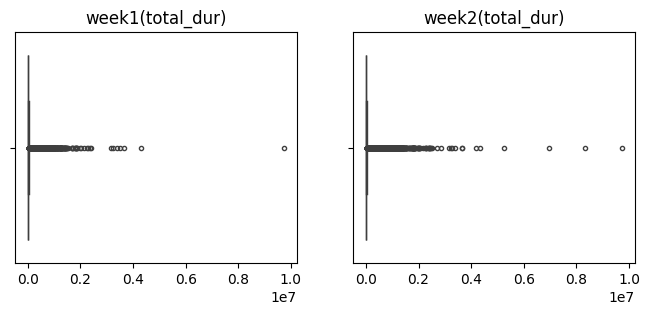

In [7]:
fig, axs = plt.subplots(ncols=2, figsize=(8, 3))
sns.boxplot(week1['total_dur'].values, fliersize=3, orient='h', ax=axs[0]).set_title('week1(total_dur)')
sns.boxplot(week2['total_dur'].values, fliersize=3, orient='h', ax=axs[1]).set_title('week2(total_dur)');

In [8]:
# Удалим выбросы в 3-х стандартных отклонениях

print(week1.shape)
week1 = week1[(week1['total_dur'] < week1['total_dur'].std() * 3)]
print(week1.shape)

print(week2.shape)
week2 = week2[(week2['total_dur'] < week2['total_dur'].std() * 3)]
print(week2.shape)

(185907, 2)
(183790, 2)
(279129, 2)
(275616, 2)


Text(0.5, 1.0, 'week2(total_dur)')

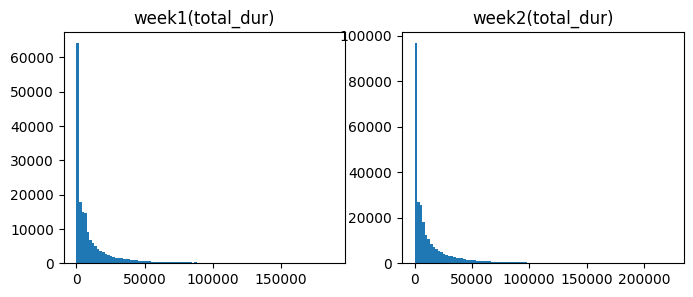

In [9]:
fig, axs = plt.subplots(ncols=2, figsize=(8, 3))
week1['total_dur'].hist(bins=100, ax=axs[0], grid=False).set_title("week1(total_dur)")
week2['total_dur'].hist(bins=100, ax=axs[1], grid=False).set_title("week2(total_dur)")

In [10]:
print(f"Week1(total_dur): mean={week1.total_dur.mean():.0f} std={week1.total_dur.std():.0f}")
print(f"Week2(total_dur): mean={week2.total_dur.mean():.0f} std={week2.total_dur.std():.0f}")

Week1(total_dur): mean=13375 std=23355
Week2(total_dur): mean=16222 std=28341


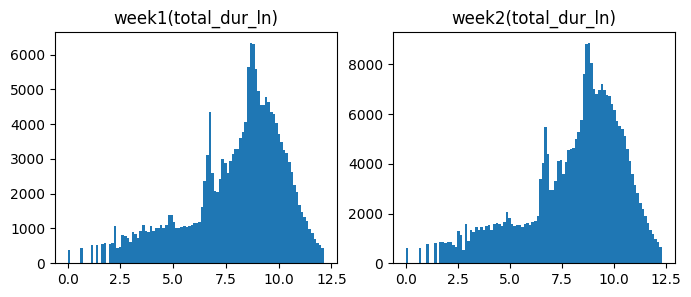

In [11]:
week1['total_dur_ln'] = np.log(week1['total_dur'])
week2['total_dur_ln'] = np.log(week2['total_dur'])

fig, axs = plt.subplots(ncols=2, figsize=(8, 3))
week1['total_dur_ln'].hist(bins=100, ax=axs[0], grid=False).set_title("week1(total_dur_ln)")
week2['total_dur_ln'].hist(bins=100, ax=axs[1], grid=False).set_title("week2(total_dur_ln)");

In [12]:
print(f"Week1(total_dur_ln): mean={week1.total_dur_ln.mean():.0f} std={week1.total_dur_ln.std():.0f}")
print(f"Week2(total_dur_ln): mean={week2.total_dur_ln.mean():.0f} std={week2.total_dur_ln.std():.0f}")

Week1(total_dur_ln): mean=8 std=2
Week2(total_dur_ln): mean=8 std=2


## 2. Подбор пары: метрика + статистический тест

In [13]:
def salt_generator() -> str:
    salt = os.urandom(8)
    return b64encode(salt).decode('ascii')


def groups_splitter(df: pd.DataFrame, 
                    columns: list[str], 
                    user_salt: str | None = None) -> pd.DataFrame:
    salt = user_salt if user_salt else salt_generator()
    
    df = df.copy()
    df['hash'] = ((df['user_id'].astype(str)) + '#' + salt).apply(lambda x: hashlib.sha256(x.encode('utf-8')).hexdigest())
    df['group'] = ((df['hash'].str.slice(start=-6).apply(int, base=16) % 2).map(lambda x: 'A' if x == 0 else 'B'))
    return df[columns]


def calc_pvalue(week: pd.DataFrame, 
                col: str = 'total_dur', 
                criterion: Callable = stats.mannwhitneyu) -> float:
    week_groups = groups_splitter(week, columns=['user_id', col, 'group'])
    _, p = criterion(
        week_groups[week_groups['group'] == 'A'][col].values,
        week_groups[week_groups['group'] == 'B'][col].values
    )
    return p


Валидация:

**Распределение ```p_value```** при корректном подборе пары метрика + критерий - равномерное распределение

**Корректность** - вероятность того, что найдет различие, когда его нет

$$significance = P(\text{reject }H_0 | H_0 \text{ is true})$$
$$ \alpha = significance $$

**Мощность** - вероятность того, что критерий найдет различие в случае, когда оно есть

$$power = P(\text{reject }H_0 | H_1 \text{ is true})$$
$$ \beta = 1 - power = P(\text{accept }H_0 | H_1 \text{ is true}) $$


### 1. ```total_dur```

In [313]:
metric_column = "total_dur"

- **Манна-Уитни** для ```week1```:

CPU times: total: 1min 16s
Wall time: 2min


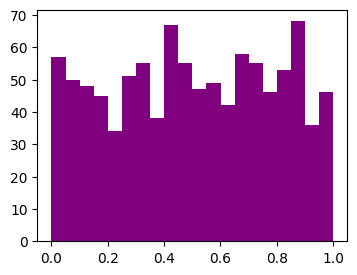

In [314]:
%%time
criterion=stats.mannwhitneyu

pvalues_week1 = Parallel(n_jobs=-1)(delayed(calc_pvalue)(week1, metric_column, criterion) for _ in range(1000))
plt.hist(pvalues_week1, bins=20, color='purple');

In [315]:
stat, p_value = scipy.stats.kstest(pvalues_week1, scipy.stats.uniform(loc=0.0, scale=1.0).cdf)
if p_value < 0.05:
    print(f'p_value = {p_value} - p_values неравномерное распределение')
else:
    print(f'p_value = {p_value} - p_values равномерное распределение')

x = np.array(pvalues_week1)
print("week1: Доля экспериментов, в которых H_0 была отвергнута (Манна-Уитни):", x[x < 0.05].shape[0] / x.shape[0])

p_value = 0.5076940804652883 - p_values равномерное распределение
week1: Доля экспериментов, в которых H_0 была отвергнута (Манна-Уитни): 0.055


- **Манна-Уитни** для ```week2```:

CPU times: total: 1min 58s
Wall time: 2min 54s


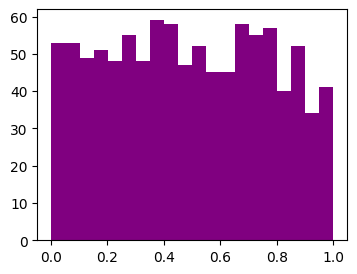

In [316]:
%%time
criterion=stats.mannwhitneyu

pvalues_week2 = Parallel(n_jobs=-1)(delayed(calc_pvalue)(week2, metric_column, criterion) for _ in range(1000))
plt.hist(pvalues_week2, bins=20, color='purple');

In [317]:
stat, p_value = scipy.stats.kstest(pvalues_week2, scipy.stats.uniform(loc=0.0, scale=1.0).cdf)
if p_value < 0.05:
    print(f'p_value = {p_value} - p_values неравномерное распределение')
else:
    print(f'p_value = {p_value} - p_values равномерное распределение')

x = np.array(pvalues_week2)
print("week2: Доля экспериментов, в которых H_0 была отвергнута (Манна-Уитни):", x[x < 0.05].shape[0] / x.shape[0])

p_value = 0.11242248470512628 - p_values равномерное распределение
week2: Доля экспериментов, в которых H_0 была отвергнута (Манна-Уитни): 0.049


- **t-test** для ```week1```:

CPU times: total: 1min 22s
Wall time: 1min 42s


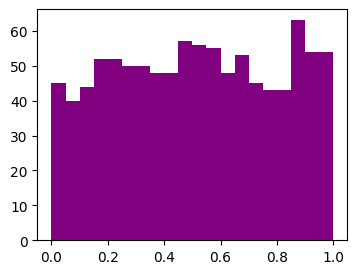

In [318]:
%%time
criterion=stats.ttest_ind

pvalues_week1_ttest = Parallel(n_jobs=-1)(delayed(calc_pvalue)(week1, metric_column, criterion) for _ in range(1000))
plt.hist(pvalues_week1_ttest, bins=20, color='purple');

In [319]:
stat, p_value = scipy.stats.kstest(pvalues_week1_ttest, scipy.stats.uniform(loc=0.0, scale=1.0).cdf)
if p_value < 0.05:
    print(f'p_value = {p_value} - p_values неравномерное распределение')
else:
    print(f'p_value = {p_value} - p_values равномерное распределение')

x = np.array(pvalues_week1_ttest)
print("week1: Доля экспериментов, в которых H_0 была отвергнута (t-test):", x[x < 0.05].shape[0] / x.shape[0])

p_value = 0.5183924034553247 - p_values равномерное распределение
week1: Доля экспериментов, в которых H_0 была отвергнута (t-test): 0.045


- **t-test** для ```week2```:

CPU times: total: 1min 53s
Wall time: 2min 26s


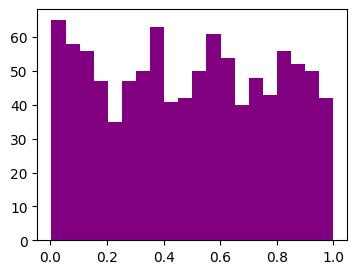

In [320]:
%%time
criterion=stats.ttest_ind

pvalues_week2_ttest = Parallel(n_jobs=-1)(delayed(calc_pvalue)(week2, metric_column, criterion) for _ in range(1000))
plt.hist(pvalues_week2_ttest, bins=20, color='purple');

In [321]:
stat, p_value = scipy.stats.kstest(pvalues_week2_ttest, scipy.stats.uniform(loc=0.0, scale=1.0).cdf)
if p_value < 0.05:
    print(f'p_value = {p_value} - p_values неравномерное распределение')
else:
    print(f'p_value = {p_value} - p_values равномерное распределение')

x = np.array(pvalues_week2_ttest)
print("week1: Доля экспериментов, в которых H_0 была отвергнута (t-test):", x[x < 0.05].shape[0] / x.shape[0])

p_value = 0.2988559847223685 - p_values равномерное распределение
week1: Доля экспериментов, в которых H_0 была отвергнута (t-test): 0.061


### 2. ```total_dur_ln```

In [322]:
metric_column = "total_dur_ln"

- **Манна-Уитни** для ```week1```:

CPU times: total: 1min 24s
Wall time: 1min 50s


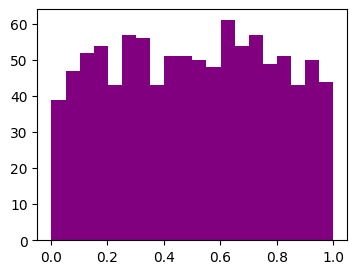

In [323]:
%%time
criterion=stats.mannwhitneyu

pvalues_week1 = Parallel(n_jobs=-1)(delayed(calc_pvalue)(week1, metric_column, criterion) for _ in range(1000))
plt.hist(pvalues_week1, bins=20, color='purple');

In [324]:
stat, p_value = scipy.stats.kstest(pvalues_week1, scipy.stats.uniform(loc=0.0, scale=1.0).cdf)
if p_value < 0.05:
    print(f'p_value = {p_value} - p_values неравномерное распределение')
else:
    print(f'p_value = {p_value} - p_values равномерное распределение')

x = np.array(pvalues_week1)
print("week1: Доля экспериментов, в которых H_0 была отвергнута (Манна-Уитни):", x[x < 0.05].shape[0] / x.shape[0])

p_value = 0.8689500159735459 - p_values равномерное распределение
week1: Доля экспериментов, в которых H_0 была отвергнута (Манна-Уитни): 0.037


- **Манна-Уитни** для ```week2```:

CPU times: total: 2min 2s
Wall time: 2min 38s


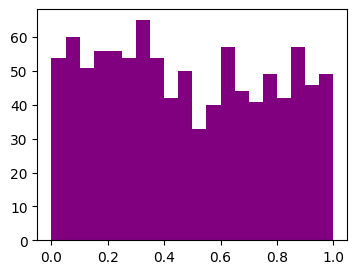

In [325]:
%%time
criterion=stats.mannwhitneyu

pvalues_week2 = Parallel(n_jobs=-1)(delayed(calc_pvalue)(week2, metric_column, criterion) for _ in range(1000))
plt.hist(pvalues_week2, bins=20, color='purple');

In [326]:
stat, p_value = scipy.stats.kstest(pvalues_week2, scipy.stats.uniform(loc=0.0, scale=1.0).cdf)
if p_value < 0.05:
    print(f'p_value = {p_value} - p_values неравномерное распределение')
else:
    print(f'p_value = {p_value} - p_values равномерное распределение')

x = np.array(pvalues_week2)
print("week2: Доля экспериментов, в которых H_0 была отвергнута (Манна-Уитни):", x[x < 0.05].shape[0] / x.shape[0])

p_value = 0.008588550701006427 - p_values неравномерное распределение
week2: Доля экспериментов, в которых H_0 была отвергнута (Манна-Уитни): 0.053


- **t-test** для ```week1```:

CPU times: total: 1min 21s
Wall time: 1min 40s


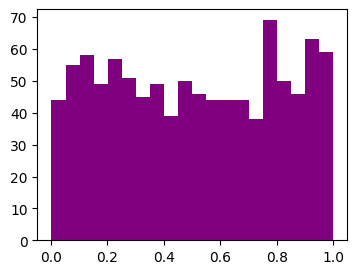

In [327]:
%%time
criterion=stats.ttest_ind

pvalues_week1_ttest = Parallel(n_jobs=-1)(delayed(calc_pvalue)(week1, metric_column, criterion) for _ in range(1000))
plt.hist(pvalues_week1_ttest, bins=20, color='purple');

In [328]:
stat, p_value = scipy.stats.kstest(pvalues_week1_ttest, scipy.stats.uniform(loc=0.0, scale=1.0).cdf)
if p_value < 0.05:
    print(f'p_value = {p_value} - p_values неравномерное распределение')
else:
    print(f'p_value = {p_value} - p_values равномерное распределение')

x = np.array(pvalues_week1_ttest)
print("week1: Доля экспериментов, в которых H_0 была отвергнута (t-test):", x[x < 0.05].shape[0] / x.shape[0])

p_value = 0.07223131279339201 - p_values равномерное распределение
week1: Доля экспериментов, в которых H_0 была отвергнута (t-test): 0.042


- **t-test** для ```week2```:

CPU times: total: 1min 56s
Wall time: 2min 26s


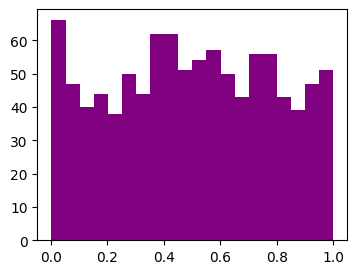

In [329]:
%%time
criterion=stats.ttest_ind

pvalues_week2_ttest = Parallel(n_jobs=-1)(delayed(calc_pvalue)(week2, metric_column, criterion) for _ in range(1000))
plt.hist(pvalues_week2_ttest, bins=20, color='purple');

In [330]:
stat, p_value = scipy.stats.kstest(pvalues_week2_ttest, scipy.stats.uniform(loc=0.0, scale=1.0).cdf)
if p_value < 0.05:
    print(f'p_value = {p_value} - p_values неравномерное распределение')
else:
    print(f'p_value = {p_value} - p_values равномерное распределение')

x = np.array(pvalues_week2_ttest)
print("week1: Доля экспериментов, в которых H_0 была отвергнута (t-test):", x[x < 0.05].shape[0] / x.shape[0])

p_value = 0.45022923857113795 - p_values равномерное распределение
week1: Доля экспериментов, в которых H_0 была отвергнута (t-test): 0.064


**Вывод**:

- все распределения ```p_values``` равномерны
- ошибка первого рода варьируется около 0.05 для t-test и Манна-Уитни в зависимости от разбиения

## 3. Дизайн A/B на Бутстрапе

#### Немного ускорил вычисления

In [14]:
@njit(parallel=True)
def calc_bootstrap_mean(arr: np.array, size = 1000) -> np.array:
    samplings = np.empty(size, dtype=float32)
    for i in range(size):
        sampling = np.random.choice(arr, size=arr.size, replace=True)
        mean = np.mean(sampling)
        samplings[i] = mean
    return samplings


def bootstrap_correctness(week: pd.DataFrame, metric_column: str, alpha=0.05) -> (np.array, bool):
    new_df = groups_splitter(week, columns=['user_id', metric_column, 'group'])

    vec_a = new_df[(new_df['group'] == 'A')][metric_column]
    vec_b = new_df[(new_df['group'] == 'B')][metric_column]

    sample_a_mean = calc_bootstrap_mean(vec_a.to_numpy(), size=1000)
    sample_b_mean = calc_bootstrap_mean(vec_b.to_numpy(), size=1000)
    diff_mean = sample_a_mean - sample_b_mean

    # Compute the confidence interval (e.g., 95% CI)
    left_side, right_side = np.percentile(diff_mean, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    # Reject equality of means when it's true
    is_this_first_type_error = not left_side <= 0 <= right_side
    
    return diff_mean, is_this_first_type_error

In [15]:
def generate_tweedie(mu, shape, p=1.4, phi=25):
    tw = tweedie_gen()
    return tw(p=p, mu=mu, phi=phi).rvs(shape)


def bootstrap_power(week: pd.DataFrame, metric_col: str, effect: float, alpha=0.05) -> (np.array, bool):
    new_df = groups_splitter(week, columns=['user_id', metric_col, 'group'])

    vec_a = new_df[(new_df['group'] == 'A')][metric_col]
    vec_b = new_df[(new_df['group'] == 'B')][metric_col]

    # Effect
    tw_values = generate_tweedie(effect * vec_b.mean(), vec_b.size)
    if metric_col == "total_dur_ln":
        tw_values[tw_values > 0] = np.log(tw_values[tw_values > 0])
    vec_b += tw_values

    sample_a_mean = calc_bootstrap_mean(vec_a.to_numpy(), size=1000)
    sample_b_mean = calc_bootstrap_mean(vec_b.to_numpy(), size=1000)
    diff_mean = sample_a_mean - sample_b_mean

    # Compute the confidence interval (e.g., 95% CI)
    left_side, right_side = np.percentile(diff_mean, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    # Do not reject the equality of means when it's necessary to reject
    is_this_second_type_error = left_side <= 0 <= right_side

    return is_this_second_type_error

In [16]:
def get_p_value(dist):
    dist = np.array(dist)
    x = (dist > 0).mean()
    pvalue = min(x, 1 - x) * 2
    return pvalue

In [17]:
N = 1000
alpha_results = []
beta_results = []

### 3.1. Корректность

#### АА тест

In [19]:
def test_correctness(week, metric_column):
    result = Parallel(n_jobs=-1)(delayed(bootstrap_correctness)(week, metric_column) for _ in range(N))
    
    p_values = [get_p_value(x[0]) for x in result]
    
    first_type_errors = [x[1] for x in result]
    alpha = sum(first_type_errors) / len(first_type_errors)
    
    print(f"I type error: {alpha:.2f}")
    
    stat, p_value = scipy.stats.kstest(p_values, scipy.stats.uniform(loc=0.0, scale=1.0).cdf)
    if p_value < 0.05:
        print(f'p_value = {p_value} - p_values неравномерное распределение')
    else:
        print(f'p_value = {p_value} - p_values равномерное распределение')
    return p_values, alpha

#### 1. ```week1```

In [20]:
%%time

metric_column="total_dur"

p_values, alpha = test_correctness(week1, metric_column)
alpha_results.append({"week": "week1", "metric_column": metric_column, "alpha": alpha})

I type error: 0.05
p_value = 0.040396397741065626 - p_values неравномерное распределение
CPU times: total: 1min 42s
Wall time: 8min 4s


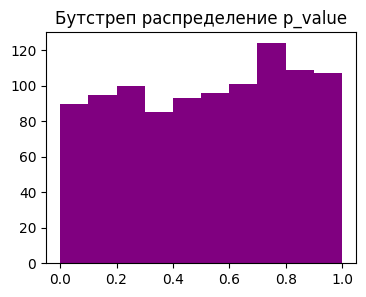

In [21]:
plt.rcParams["figure.figsize"] = (4,3)
plt.hist(p_values, bins=10, color='purple')
plt.title(f"Бутстреп распределение p_value");

In [22]:
%%time

metric_column="total_dur_ln"

p_values, alpha = test_correctness(week1, metric_column)
alpha_results.append({"week": "week1", "metric_column": metric_column, "alpha": alpha})

I type error: 0.05
p_value = 0.8108971656895569 - p_values равномерное распределение
CPU times: total: 1min 58s
Wall time: 8min 48s


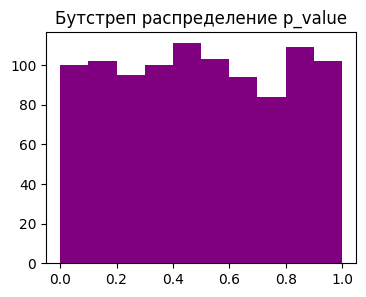

In [23]:
plt.rcParams["figure.figsize"] = (4,3)
plt.hist(p_values, bins=10, color='purple')
plt.title(f"Бутстреп распределение p_value");

#### 2. ```week2```

In [24]:
%%time

metric_column="total_dur"

p_values, alpha = test_correctness(week2, metric_column)
alpha_results.append({"week": "week2", "metric_column": metric_column, "alpha": alpha})

I type error: 0.05
p_value = 0.45169720730901186 - p_values равномерное распределение
CPU times: total: 2min 18s
Wall time: 14min 28s


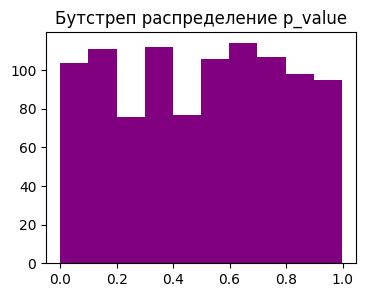

In [25]:
plt.rcParams["figure.figsize"] = (4,3)
plt.hist(p_values, bins=10, color='purple')
plt.title(f"Бутстреп распределение p_value");

In [26]:
%%time

metric_column="total_dur_ln"

p_values, alpha = test_correctness(week2, metric_column)
alpha_results.append({"week": "week2", "metric_column": metric_column, "alpha": alpha})

I type error: 0.04
p_value = 0.7097553870118938 - p_values равномерное распределение
CPU times: total: 3min 12s
Wall time: 17min 2s


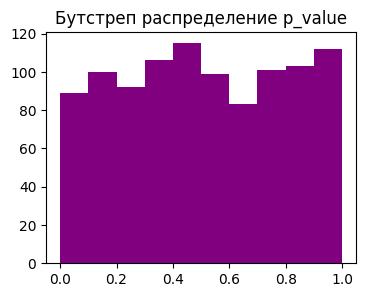

In [27]:
plt.rcParams["figure.figsize"] = (4,3)
plt.hist(p_values, bins=10, color='purple')
plt.title(f"Бутстреп распределение p_value");

#### Результаты Корректности:

In [28]:
pd.DataFrame(alpha_results).set_index(["week", "metric_column"])

alpha
week  metric_column       
week1 total_dur      0.052
      total_dur_ln   0.048
week2 total_dur      0.048
      total_dur_ln   0.044

### 3.2. Мощность

#### Буду добавлять эффект с помощью Tweedie распеределения. Так это выглядит:

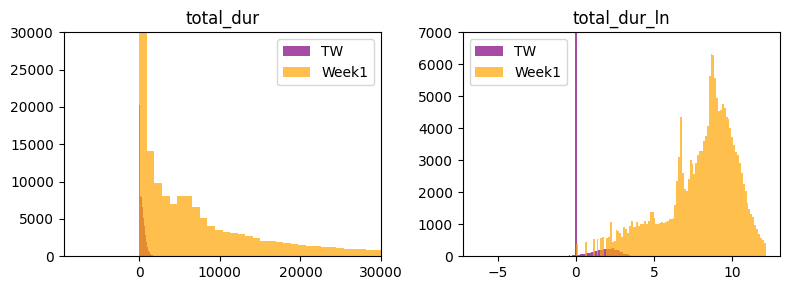

In [104]:
fig, axs = plt.subplots(ncols=2, figsize=(8,3))

effect = 0.03
tw = generate_tweedie(effect * week1.total_dur.mean(), week1.total_dur.size)

axs[0].hist(tw, bins=100, color='purple', alpha=0.7, label='TW')
axs[0].hist(week1.total_dur, bins=200, color='orange', alpha=0.7, label='Week1')
axs[0].legend()
axs[0].set_title('total_dur')
axs[0].axis(ymax=30000, xmax=30000)

tw = generate_tweedie(effect * week1.total_dur_ln.mean(), week1.total_dur_ln.size)
tw[tw > 0] = np.log(tw[tw > 0])

axs[1].hist(tw, bins=100, color='purple', alpha=0.7, label='TW')
axs[1].hist(week1.total_dur_ln, bins=100, color='orange', alpha=0.7, label='Week1')
axs[1].legend()
axs[1].set_title('total_dur_ln')
axs[1].axis(ymax=7000)

plt.tight_layout()
plt.show()

In [29]:
def test_power(week, metric_column, effect):
    second_type_errors = Parallel(n_jobs=-1)(delayed(bootstrap_power)(week, metric_column, effect) for _ in range(N))

    beta = sum(second_type_errors) / len(second_type_errors)    
    print(f"II type error: {beta:.2f}")
    
    return beta

#### 1. ```week1```

- Эффект 1%:

In [30]:
%%time

effect = 0.01
metric_column="total_dur"

beta = test_power(week1, metric_column, effect)
beta_results.append({"week": "week1", "metric_column": metric_column, "effect": f"{effect*100}%", "beta": beta})

II type error: 0.78
CPU times: total: 1min 39s
Wall time: 7min 51s


In [31]:
%%time

effect = 0.01
metric_column="total_dur_ln"

beta = test_power(week1, metric_column, effect)
beta_results.append({"week": "week1", "metric_column": metric_column, "effect": f"{effect*100}%", "beta": beta})

II type error: 0.56
CPU times: total: 1min 49s
Wall time: 8min 4s


- Эффект 3%:

In [32]:
%%time

effect = 0.03
metric_column="total_dur"

beta = test_power(week1, metric_column, effect)
beta_results.append({"week": "week1", "metric_column": metric_column, "effect": f"{effect*100}%", "beta": beta})

II type error: 0.05
CPU times: total: 1min 40s
Wall time: 7min 51s


In [33]:
%%time

effect = 0.03
metric_column="total_dur_ln"

beta = test_power(week1, metric_column, effect)
beta_results.append({"week": "week1", "metric_column": metric_column, "effect": f"{effect*100}%", "beta": beta})

II type error: 0.01
CPU times: total: 1min 49s
Wall time: 8min 2s


- Эффект 5%:

In [34]:
%%time

effect = 0.05
metric_column="total_dur"

beta = test_power(week1, metric_column, effect)
beta_results.append({"week": "week1", "metric_column": metric_column, "effect": f"{effect*100}%", "beta": beta})

II type error: 0.00
CPU times: total: 1min 39s
Wall time: 7min 48s


In [35]:
%%time

effect = 0.05
metric_column="total_dur_ln"

beta = test_power(week1, metric_column, effect)
beta_results.append({"week": "week1", "metric_column": metric_column, "effect": f"{effect*100}%", "beta": beta})

II type error: 0.00
CPU times: total: 1min 50s
Wall time: 8min 1s


#### 2. ```week2```

- Эффект 1%:

In [36]:
%%time

effect = 0.01
metric_column="total_dur"

beta = test_power(week2, metric_column, effect)
beta_results.append({"week": "week2", "metric_column": metric_column, "effect": f"{effect*100}%", "beta": beta})

II type error: 0.68
CPU times: total: 2min 38s
Wall time: 14min 51s


In [37]:
%%time

effect = 0.01
metric_column="total_dur_ln"

beta = test_power(week2, metric_column, effect)
beta_results.append({"week": "week2", "metric_column": metric_column, "effect": f"{effect*100}%", "beta": beta})

II type error: 0.47
CPU times: total: 3min 3s
Wall time: 16min 43s


- Эффект 3%:

In [38]:
%%time

effect = 0.03
metric_column="total_dur"

beta = test_power(week2, metric_column, effect)
beta_results.append({"week": "week2", "metric_column": metric_column, "effect": f"{effect*100}%", "beta": beta})

II type error: 0.01
CPU times: total: 2min 37s
Wall time: 15min 3s


In [39]:
%%time

effect = 0.03
metric_column="total_dur_ln"

beta = test_power(week2, metric_column, effect)
beta_results.append({"week": "week2", "metric_column": metric_column, "effect": f"{effect*100}%", "beta": beta})

II type error: 0.00
CPU times: total: 3min 2s
Wall time: 16min 38s


- Эффект 5%:

In [40]:
%%time

effect = 0.05
metric_column="total_dur"

beta = test_power(week2, metric_column, effect)
beta_results.append({"week": "week2", "metric_column": metric_column, "effect": f"{effect*100}%", "beta": beta})

II type error: 0.00
CPU times: total: 2min 37s
Wall time: 15min 1s


In [41]:
%%time

effect = 0.05
metric_column="total_dur_ln"

beta = test_power(week2, metric_column, effect)
beta_results.append({"week": "week2", "metric_column": metric_column, "effect": f"{effect*100}%", "beta": beta})

II type error: 0.00
CPU times: total: 3min 3s
Wall time: 16min 37s


#### Результаты Мощности:

In [42]:
pd.DataFrame(beta_results).set_index(["week", "metric_column", "effect"]).sort_values(["week", "metric_column"])

beta
week  metric_column effect       
week1 total_dur     1.0%    0.784
                    3.0%    0.050
                    5.0%    0.000
      total_dur_ln  1.0%    0.563
                    3.0%    0.005
                    5.0%    0.000
week2 total_dur     1.0%    0.684
                    3.0%    0.009
                    5.0%    0.000
      total_dur_ln  1.0%    0.471
                    3.0%    0.000
                    5.0%    0.000

- Эффект в 1% плохо детектируется
- Эффект в 3% детектируется в более чем 95% случаев
- Эффект в 5% детектируется в более чем 99% случаев

Стоит учесть что здесь я добавлял Tweedie эффект, а не увеличивал просмотры топ-10% пользователей, как в итоговом A/B тесте из домашнего задания.
Поэтому разные эффекты могут давать разные $\alpha$ и $\beta$

### 3.3. Оценка MDE по найденным $\alpha$ и $\beta$

$$ MDE = \frac{(z_{1 - \frac{\alpha}{2}} + z_{1 - \beta}) * \sqrt{\sigma_{control}^2 + \sigma_{experiment}^2}}{\sqrt{N}} $$

In [43]:
from scipy.stats import norm


def get_mde(metric_vec, alpha=0.05, beta=0.2):

    metric_mean, metric_std, metric_n = metric_vec.mean(), metric_vec.std(), metric_vec.count()

    z_alpha = norm.ppf(1 - (alpha / 2), loc=0, scale=1)
    z_beta = norm.ppf(1 - beta, loc=0, scale=1)

    mde = (z_alpha + z_beta)*metric_std / np.sqrt(metric_n)
    
    return mde*100/metric_mean

In [44]:
first_type_errors = [0.05, 0.1]
second_type_errors = [0.5, 0.2, 0.1, 0.05, 0.01]

```week1``` 

In [45]:
mde_week1 = []

for a in first_type_errors:
    mdes = {str(b): f"{get_mde(week1.total_dur, alpha=a, beta=b):.1f}%" for b in second_type_errors}
    mdes["alpha"] = a
    mdes["metric"] = "total_dur"
    mde_week1.append(mdes)

    mdes = {str(b): f"{np.exp(get_mde(week1.total_dur_ln, alpha=a, beta=b)):.1f}%" for b in second_type_errors}
    mdes["alpha"] = a
    mdes["metric"] = "total_dur_ln"
    mde_week1.append(mdes)
    
pd.DataFrame(mde_week1).set_index(["metric", "alpha"]).sort_values(["metric"])

0.5   0.2   0.1  0.05  0.01
metric       alpha                              
total_dur    0.05   0.8%  1.1%  1.3%  1.5%  1.7%
             0.10   0.7%  1.0%  1.2%  1.3%  1.6%
total_dur_ln 0.05   1.1%  1.2%  1.3%  1.3%  1.3%
             0.10   1.1%  1.2%  1.2%  1.3%  1.3%

```week2``` 

In [46]:
mde_week2 = []

for a in first_type_errors:
    mdes = {str(b): f"{get_mde(week2.total_dur, alpha=a, beta=b):.1f}%" for b in second_type_errors}
    mdes["alpha"] = a
    mdes["metric"] = "total_dur"
    mde_week2.append(mdes)

    mdes = {str(b): f"{np.exp(get_mde(week2.total_dur_ln, alpha=a, beta=b)):.1f}%" for b in second_type_errors}
    mdes["alpha"] = a
    mdes["metric"] = "total_dur_ln"
    mde_week2.append(mdes)
    
pd.DataFrame(mde_week2).set_index(["metric", "alpha"]).sort_values(["metric"])

0.5   0.2   0.1  0.05  0.01
metric       alpha                              
total_dur    0.05   0.7%  0.9%  1.1%  1.2%  1.4%
             0.10   0.5%  0.8%  1.0%  1.1%  1.3%
total_dur_ln 0.05   1.1%  1.2%  1.2%  1.2%  1.3%
             0.10   1.1%  1.2%  1.2%  1.2%  1.3%

**Вывод**:
- на большей выборке можем детектировать меньший эффект ☝️
- с уменьшением $\alpha$ и $\beta$ - увеличивается минимальный детектируемый эффект

## 4. A/B тест

Докину эффект 2.5% для топ-10 смотрящих пользователей. Перед этим зануляем просмотры меньше 500 (так избавляемся от шума?)

In [259]:
week1_test = week1.copy()
week2_test = week2.copy()

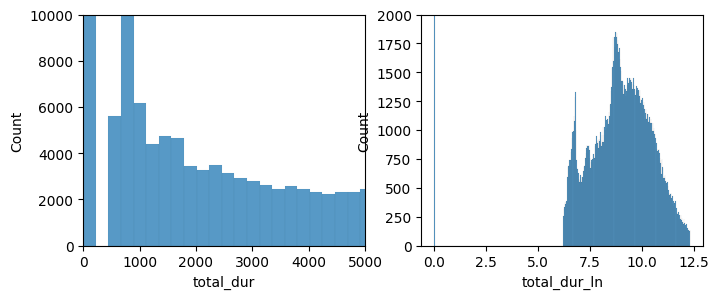

In [260]:
border = 500
week1_test.loc[week1_test["total_dur"] < border, "total_dur"] = 0
week1_test.loc[week1_test["total_dur_ln"] < np.log(border), "total_dur_ln"] = 0

week2_test.loc[week2_test["total_dur"] < border, "total_dur"] = 0
week2_test.loc[week2_test["total_dur_ln"] < np.log(border), "total_dur_ln"] = 0

f, axs = plt.subplots(ncols=2, figsize=(8,3))
sns.histplot(week2_test.total_dur, bins=1000, ax=axs[0])
axs[0].axis(xmin=0, xmax=5000, ymax=10000)
sns.histplot(week2_test.total_dur_ln, bins=500, ax=axs[1])
axs[1].axis(ymax=2000);

In [358]:
salt = "kiontestmodel20210805"
effect = 1.025

week1_groups = groups_splitter(week1_test, ["user_id", "total_dur", "total_dur_ln", "group"], user_salt=salt)
week2_groups = groups_splitter(week2_test, ["user_id", "total_dur", "total_dur_ln", "group"], user_salt=salt)

week1_groups = week1_groups.sort_values("total_dur")
week2_groups = week2_groups.sort_values("total_dur")
week1_groups.total_dur = week1_groups.total_dur.astype(float)
week2_groups.total_dur = week2_groups.total_dur.astype(float)

# week1 effect
week1_groups.loc[week1_groups.index[int(len(week1_groups) * 0.9):], "total_dur"] *= effect
week1_groups.loc[week1_groups.index[int(len(week1_groups) * 0.9):], "total_dur_ln"] += np.log(effect)

# week2 effect
week2_groups.loc[week2_groups.index[int(len(week2_groups) * 0.9):], "total_dur"] *= effect
week2_groups.loc[week2_groups.index[int(len(week2_groups) * 0.9):], "total_dur_ln"] += np.log(effect)

#### 1. ```week1```

Обычная метрика ```total_dur```

In [359]:
metric_column = "total_dur"
alpha = 0.05

vec_a = week1_groups[(week1_groups['group'] == 'A')][metric_column]
vec_b = week1_groups[(week1_groups['group'] == 'B')][metric_column]

sample_a_mean = calc_bootstrap_mean(vec_a.to_numpy(), size=1000)
sample_b_mean = calc_bootstrap_mean(vec_b.to_numpy(), size=1000)
diff_mean = sample_a_mean - sample_b_mean

left_side, right_side = np.percentile(diff_mean, [0, 100 * (1 - alpha)])
print((left_side, right_side))
print("H_0 отвергнута:", not left_side < 0 < right_side)

(-580.8505859375, 4.474462890624936)
H_0 отвергнута: False


In [360]:
metric_column = "total_dur"
criterion = stats.ttest_ind

p = criterion(week1_groups[week1_groups['group'] == 'A'][metric_column].values,
              week1_groups[week1_groups['group'] == 'B'][metric_column].values).pvalue
print("pvalue = ", p)
print("H_0 отвергнута:", p < 0.05)

pvalue =  0.11637389296923724
H_0 отвергнута: False


In [361]:
metric_column = "total_dur"
criterion = stats.mannwhitneyu

p = criterion(week1_groups[week1_groups['group'] == 'A'][metric_column].values,
              week1_groups[week1_groups['group'] == 'B'][metric_column].values).pvalue
print("pvalue = ", p)
print("H_0 отвергнута:", p < 0.05)

pvalue =  0.008600358354265631
H_0 отвергнута: True


Логарифмированная метрика ```total_dur_ln```

In [362]:
metric_column = "total_dur_ln"
alpha = 0.05

vec_a = week1_groups[(week1_groups['group'] == 'A')][metric_column]
vec_b = week1_groups[(week1_groups['group'] == 'B')][metric_column]

sample_a_mean = calc_bootstrap_mean(vec_a.to_numpy(), size=1000)
sample_b_mean = calc_bootstrap_mean(vec_b.to_numpy(), size=1000)
diff_mean = sample_a_mean - sample_b_mean

left_side, right_side = np.percentile(diff_mean, [0, 100 * (1 - alpha)])
print((left_side, right_side))
print("H_0 отвергнута:", not left_side < 0 < right_side)

(-0.10604047775268555, -0.022415471076965333)
H_0 отвергнута: True


In [363]:
metric_column = "total_dur_ln"
criterion = stats.ttest_ind

p = criterion(week1_groups[week1_groups['group'] == 'A'][metric_column].values,
              week1_groups[week1_groups['group'] == 'B'][metric_column].values).pvalue
print("pvalue = ", p)
print("H_0 отвергнута:", p < 0.05)

pvalue =  0.0033017595566961315
H_0 отвергнута: True


In [364]:
metric_column = "total_dur_ln"
criterion = stats.mannwhitneyu

p = criterion(week1_groups[week1_groups['group'] == 'A'][metric_column].values,
              week1_groups[week1_groups['group'] == 'B'][metric_column].values).pvalue
print("pvalue = ", p)
print("H_0 отвергнута:", p < 0.05)

pvalue =  0.008600358354265631
H_0 отвергнута: True


**Выводы по ```week1```**:

1. Обычная метрика```total_dur``` оказалась "сомнительной".
    - После проведения А/А теста на **бутстрапе** распределение ```p-values``` было **неравномерным**. Наверно, поэтому **H_0 не отвергнута** на бутстрапе
    - После проведения A/A теста на **критерии Манна-Уитни** распределение ```p-values``` было равномерным. Наверно, поэтому на этом критерии **H_0 была отвергнута**
  
2. ```total_dur_ln``` стабильно отверг H_0 всеми стат. критериями

#### 2. ```week2```

Обычная метрика ```total_dur```

In [365]:
metric_column = "total_dur"
alpha = 0.05

vec_a = week2_groups[(week2_groups['group'] == 'A')][metric_column]
vec_b = week2_groups[(week2_groups['group'] == 'B')][metric_column]

sample_a_mean = calc_bootstrap_mean(vec_a.to_numpy(), size=1000)
sample_b_mean = calc_bootstrap_mean(vec_b.to_numpy(), size=1000)
diff_mean = sample_a_mean - sample_b_mean

left_side, right_side = np.percentile(diff_mean, [0, 100 * (1 - alpha)])
print((left_side, right_side))
print("H_0 отвергнута:", not left_side < 0 < right_side)

(-368.7138671875, 169.54951171874995)
H_0 отвергнута: False


In [366]:
metric_column = "total_dur"
criterion = stats.ttest_ind

p = criterion(week2_groups[week2_groups['group'] == 'A'][metric_column].values,
              week2_groups[week2_groups['group'] == 'B'][metric_column].values).pvalue
print("pvalue = ", p)
print("H_0 отвергнута:", p < 0.05)

pvalue =  0.8856454065902274
H_0 отвергнута: False


In [367]:
metric_column = "total_dur"
criterion = stats.mannwhitneyu

p = criterion(week2_groups[week2_groups['group'] == 'A'][metric_column].values,
              week2_groups[week2_groups['group'] == 'B'][metric_column].values).pvalue
print("pvalue = ", p)
print("H_0 отвергнута:", p < 0.05)

pvalue =  0.12022000803279449
H_0 отвергнута: False


Логарифмированная метрика ```total_dur_ln```

In [368]:
metric_column = "total_dur_ln"
alpha = 0.05

vec_a = week2_groups[(week2_groups['group'] == 'A')][metric_column]
vec_b = week2_groups[(week2_groups['group'] == 'B')][metric_column]

sample_a_mean = calc_bootstrap_mean(vec_a.to_numpy(), size=1000)
sample_b_mean = calc_bootstrap_mean(vec_b.to_numpy(), size=1000)
diff_mean = sample_a_mean - sample_b_mean

left_side, right_side = np.percentile(diff_mean, [0, 100 * (1 - alpha)])
print((left_side, right_side))
print("H_0 отвергнута:", not left_side < 0 < right_side)

(-0.06935548782348633, -0.0010578632354736356)
H_0 отвергнута: True


In [369]:
metric_column = "total_dur_ln"
criterion = stats.ttest_ind

p = criterion(week2_groups[week2_groups['group'] == 'A'][metric_column].values,
              week2_groups[week2_groups['group'] == 'B'][metric_column].values).pvalue
print("pvalue = ", p)
print("H_0 отвергнута:", p < 0.05)

pvalue =  0.10256990189451833
H_0 отвергнута: False


In [370]:
metric_column = "total_dur_ln"
criterion = stats.mannwhitneyu

p = criterion(week2_groups[week2_groups['group'] == 'A'][metric_column].values,
              week2_groups[week2_groups['group'] == 'B'][metric_column].values).pvalue
print("pvalue = ", p)
print("H_0 отвергнута:", p < 0.05)

pvalue =  0.12022000803279449
H_0 отвергнута: False


**Выводы по ```week2```**:

1. ```total_dur``` H_0 не отвергнута
  
2. ```total_dur_ln``` принимаем H_a в случае бутстрапа

Осталось несколько недопониманий: 

1. Я делал дизайн A/B теста на данных, которые отличались от данных, где я моделировал 2.5% эффект. То есть, я не отрезал всё что меньше 500 и при поиске мощности докидывал другой эффект (твиди, вместо топ-10). Думаю, что это не окей и нужно было в самом начале "подогнать" данные под финальный тест, что тоже сомнительно из-за заглядывания в будущее.

2. Стат. критерии (t-test и Манна-Уитни) дают равномерное распределение ```p_values```, но при этом не находят эффект в финальном тесте. Возможно, это опять же из-за изменения данных, ведь я проверял корректность их применения на необрезанных данных.

По итогу единственной "правдивой" парой оказались ```total_dur_ln``` + Бутстрап, которые нашли эффект.

# ДЗ 1:

### Дизайн теста
1) Из interactions взять данные за 2 последние недели (2021-08-09 по 2021-08-22)

2) Посчитайте на этих данных корректность на бутстрепе и сравните ее с результатами за 1 неделю (посчитано на семинаре) (0.5 балла)

3) На двух неделях посчитайте мощность. Для этого нужно в одну из групп докинуть эффект. Докиньте эффект в 1%, 3% и 5% и сравните полученную мощность (1.5 балла)

4) Посчитайте MDE, который можно зафиксировать на 2х неделях. В качестве alpha и beta подставьте ваши вычисленные ошибки 1 и 2 рода. Учитывайте что у нас формула для MDE работает для t-test или z-test (1 балл)

### A/B тест
1) Представим что у нас прошел тест, используем те же самые данные за 2 недели

2) Занулите для всех пользователей total_dur, у которых total_dur < 500. Их НЕ УБИРАЕМ, а просто обрабатываем эти значения, принимая за нулевые, но пользователей также учитываем в эксперименте (0.5 балла)

3) Разбейте их самостоятельно на две равные группы, используйте функцию groups_splitter и соль = 'kiontestmodel20210805' (0.5 балла)

4) Оказалось, что модель в группе В показала себя лучше, чем в группе А на 2.5%, причем эффект распространился неравномерно и преимущественно на 10% самых смотрящих пользователей, докиньте такой эффект самостоятельно. Нужно метрику total_dur увеличить на 2.5% для 10% пользователей с самым продолжительным смотрением. (1 балл)

5) Посчитайте результат такого теста и сделайте выводы (2 балла)

Еще 1 балл можно получить за хорошее и подробное объяснение каждого шага

СОВЕТ: Т.к бутстрэп считается долго, то для дз отлаживаем код на малом количестве итераций, а результаты уже показываем на 1000+